In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Model imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, BatchNormalization, Dropout, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define column names
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

# Load Data (Update path as necessary)
path = '/content/drive/MyDrive/Colab Notebooks/NASA Turbofan Jet Engine Data Set/data/'
df_train = pd.read_csv('/content/train_FD002.txt', sep='\s+', header=None, index_col=False, names=col_names)
df_test = pd.read_csv('/content/test_FD002.txt', sep='\s+', header=None, index_col=False, names=col_names)
y_test = pd.read_csv('/content/RUL_FD002.txt', sep='\s+', header=None, index_col=False, names=['RUL'])

<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4160232002.py:31: SyntaxWarning: invalid escape sequence '\s'
  df_train = pd.read_csv('/content/train_FD002.txt', sep='\s+', header=None, index_col=False, names=col_names)
/tmp/ipython-input-4160232002.py:32: SyntaxWarning: invalid escape sequence '\s'
  df_test = pd.read_csv('/content/test_FD002.txt', sep='\s+', header=None, index_col=False, names=col_names)
/tmp/ipython-input-4160232002.py:33: SyntaxWarning: invalid escape sequence '\s'
  y_test = pd.read_csv('/content/RUL_FD002.txt', sep='\s+', header=None, index_col=False, names=['RUL'])


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

# 1. Setup column names
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

def scale_and_export_fd002(train_txt_path, test_txt_path):
    print(f"Loading raw data from {train_txt_path} and {test_txt_path}...")
    # Load raw text files
    df_train = pd.read_csv(train_txt_path, sep='\s+', header=None, index_col=False, names=col_names)
    df_test = pd.read_csv(test_txt_path, sep='\s+', header=None, index_col=False, names=col_names)

    # 2. Dynamic Feature Selection (as per your FD002 notebook)
    # Identify sensors that don't change (constant values)
    drop_cols = df_train.columns[df_train.nunique() <= 1].tolist()
    print(f"Dropping constant columns: {drop_cols}")

    # 3. Scaling Logic
    scaler = MinMaxScaler()

    # Define features to scale (everything except unit_number and constant columns)
    # Note: 'unit_number' is removed before scaling but re-attached later
    train_features = df_train.drop(columns=['unit_number'] + drop_cols)
    test_features = df_test.drop(columns=['unit_number'] + drop_cols)

    print("Fitting and transforming data...")
    train_scaled = scaler.fit_transform(train_features)
    test_scaled = scaler.transform(test_features)

    # 4. Re-attach 'unit_number' as the first column (needed for your windowing functions)
    final_train = pd.DataFrame(data=np.c_[df_train["unit_number"], train_scaled])
    final_test = pd.DataFrame(data=np.c_[df_test["unit_number"], test_scaled])

    # 5. Export Files
    train_output = 'scaled_train_FD002.csv'
    test_output = 'scaled_test_FD002.csv'
    scaler_output = 'scaler_FD002.pkl'

    final_train.to_csv(train_output, index=False)
    final_test.to_csv(test_output, index=False)
    joblib.dump(scaler, scaler_output)

    print("\n--- Process Complete ---")
    print(f"1. Saved Scaled Train Data: {train_output}")
    print(f"2. Saved Scaled Test Data: {test_output}")
    print(f"3. Saved Scaler Object: {scaler_output}")
    print("You can now use these CSVs in your model or upload the .pkl to your dashboard.")

# EXECUTION (Ensure your .txt files are in the same folder or provide the full path)
# scale_and_export_fd002('train_FD002.txt', 'test_FD002.txt')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

Training CNN...
Training LSTM...

--- PERFORMANCE SUMMARY ---
Model      RMSE       R2
  CNN 31.597269 0.654795
 LSTM 31.352055 0.660132


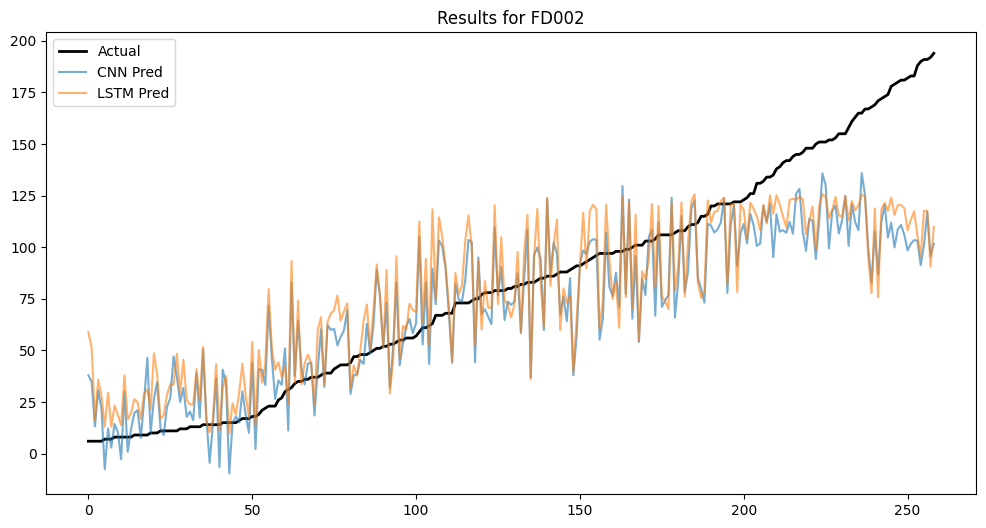

Exported best model: FD002model.h5


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, Sequential

warnings.filterwarnings('ignore')

# 1. CONFIGURATION
DATASET_ID = 'FD002'
PATH = '/content/drive/MyDrive/Colab Notebooks/NASA Turbofan Jet Engine Data Set/data/'

index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

# Load Data
path = '/content/drive/MyDrive/Colab Notebooks/NASA Turbofan Jet Engine Data Set/data/'
df_train = pd.read_csv('/content/train_FD002.txt', sep='\s+', header=None, index_col=False, names=col_names)
df_test = pd.read_csv('/content/test_FD002.txt', sep='\s+', header=None, index_col=False, names=col_names)
y_test = pd.read_csv('/content/RUL_FD002.txt', sep='\s+', header=None, index_col=False, names=['RUL'])

# 2. UPDATED PREPROCESSING WITH PADDING
def process_targets(data_length, early_rul):
    if data_length <= early_rul:
        return np.arange(data_length - 1, -1, -1)
    else:
        return np.append(early_rul * np.ones(data_length - early_rul), np.arange(early_rul - 1, -1, -1))

def process_input_data_with_targets(input_data, target_data, window_length, shift):
    # ADD PADDING: If input is shorter than window_length, pad with zeros
    if len(input_data) < window_length:
        padding_len = window_length - len(input_data)
        input_data = np.pad(input_data, ((padding_len, 0), (0, 0)), mode='constant')
        if target_data is not None:
            # For targets, we pad with the first RUL value (the highest)
            target_data = np.pad(target_data, (padding_len, 0), mode='edge')

    num_batches = int(np.floor((len(input_data) - window_length) / shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.zeros((num_batches, window_length, num_features))

    if target_data is None:
        for batch in range(num_batches):
            output_data[batch, :, :] = input_data[(batch * shift):(batch * shift + window_length), :]
        return output_data
    else:
        output_targets = np.zeros(num_batches)
        for batch in range(num_batches):
            start, end = batch * shift, batch * shift + window_length
            output_data[batch, :, :] = input_data[start:end, :]
            output_targets[batch] = target_data[end - 1]
        return output_data, output_targets

def process_test_data(test_data_unit, window_length, shift, num_test_windows=5):
    # Ensure test unit has at least window_length rows via padding
    if len(test_data_unit) < window_length:
        padding_len = window_length - len(test_data_unit)
        test_data_unit = np.pad(test_data_unit, ((padding_len, 0), (0, 0)), mode='constant')

    max_batches = int(np.floor((len(test_data_unit) - window_length) / shift)) + 1
    num_windows = min(max_batches, num_test_windows)
    required_len = (num_windows - 1) * shift + window_length
    batched_data = process_input_data_with_targets(test_data_unit[-required_len:, :], None, window_length, shift)
    return batched_data, num_windows

# 3. FEATURE SELECTION & SCALING
drop_cols = df_train.columns[df_train.nunique() <= 1].tolist()
scaler = MinMaxScaler()
train_features = df_train.drop(columns=['unit_number'] + drop_cols)
test_features = df_test.drop(columns=['unit_number'] + drop_cols)

train_scaled = scaler.fit_transform(train_features)
test_scaled = scaler.transform(test_features)
num_features = train_scaled.shape[1]

# 4. DATA PREPARATION
window_length, shift, early_rul = 30, 1, 125
X_train_list, Y_train_list = [], []

for unit in df_train['unit_number'].unique():
    unit_data = train_scaled[df_train['unit_number'] == unit]
    unit_target = process_targets(len(unit_data), early_rul)
    x, y = process_input_data_with_targets(unit_data, unit_target, window_length, shift)
    X_train_list.append(x); Y_train_list.append(y)

X_train, Y_train = np.concatenate(X_train_list), np.concatenate(Y_train_list)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Prepare Test Data
X_test_list, test_window_counts = [], []
for unit in df_test['unit_number'].unique():
    unit_data = test_scaled[df_test['unit_number'] == unit]
    x, count = process_test_data(unit_data, window_length, shift, num_test_windows=5)
    X_test_list.append(x); test_window_counts.append(count)

X_test_final = np.concatenate(X_test_list)
Y_test_actual = y_test.values.flatten()

# 5. MODEL ARCHITECTURES & TRAINING
def get_models(input_shape):
    return {
        "CNN": Sequential([
            layers.Conv1D(64, 3, activation='relu', input_shape=input_shape, padding='same'),
            layers.MaxPooling1D(2),
            layers.Flatten(),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        "LSTM": Sequential([
            layers.LSTM(64, input_shape=input_shape),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
    }

models = get_models((window_length, num_features))
results_summary = []
all_predictions = {}



for name, model in models.items():
    print(f"Training {name}...")
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=128, verbose=0)

    raw_preds = model.predict(X_test_final, verbose=0).flatten()
    preds_split = np.split(raw_preds, np.cumsum(test_window_counts)[:-1])
    engine_preds = np.array([np.mean(p) for p in preds_split])

    mse = mean_squared_error(Y_test_actual, engine_preds)
    results_summary.append({'Model': name, 'RMSE': np.sqrt(mse), 'R2': r2_score(Y_test_actual, engine_preds), 'ModelObj': model})
    all_predictions[name] = engine_preds

# 6. RESULTS & VISUALS
df_results = pd.DataFrame(results_summary)
print("\n--- PERFORMANCE SUMMARY ---")
print(df_results[['Model', 'RMSE', 'R2']].to_string(index=False))

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
sort_idx = np.argsort(Y_test_actual)
plt.plot(Y_test_actual[sort_idx], color='black', label='Actual', linewidth=2)
for name, preds in all_predictions.items():
    plt.plot(preds[sort_idx], label=f'{name} Pred', alpha=0.6)
plt.legend(); plt.title(f"Results for {DATASET_ID}"); plt.show()

# Export
best_model = df_results.loc[df_results['RMSE'].idxmin()]
best_model['ModelObj'].save(f"{DATASET_ID}model.h5")
print(f"Exported best model: {DATASET_ID}model.h5")

Loading FD002...
Training CNN for FD002...
>> CNN Score: RMSE 30.09
Training GRU for FD002...
>> GRU Score: RMSE 31.47
Training LSTM for FD002...
>> LSTM Score: RMSE 32.80
Training Stacked LSTM for FD002...
>> Stacked LSTM Score: RMSE 53.80
Training Bi-LSTM for FD002...
>> Bi-LSTM Score: RMSE 32.08
Training CNN-LSTM for FD002...
>> CNN-LSTM Score: RMSE 36.00


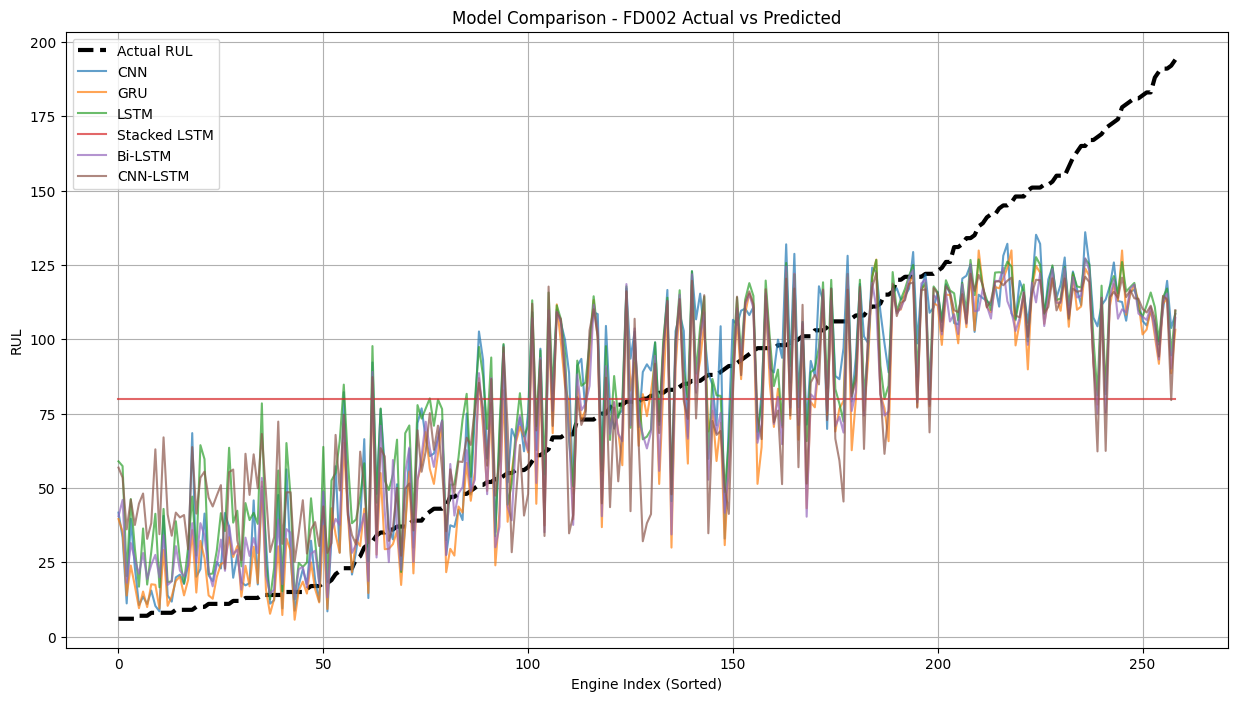


FINAL RESULTS FOR FD002
       Model         MSE      RMSE        R2
         CNN  905.693420 30.094741  0.686845
         GRU  990.328369 31.469483  0.657582
        LSTM 1075.620239 32.796650  0.628091
Stacked LSTM 2894.082031 53.796673 -0.000665
     Bi-LSTM 1028.838623 32.075514  0.644266
    CNN-LSTM 1296.309937 36.004304  0.551785

WINNER: CNN exported as FD0022model.h5


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Bidirectional, Flatten, TimeDistributed

warnings.filterwarnings('ignore')

# 1. SETUP & DATA LOADING
DATASET_ID = 'FD002'
PATH = '/content/drive/MyDrive/Colab Notebooks/NASA Turbofan Jet Engine Data Set/data/' # Adjust if needed

index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

print(f"Loading {DATASET_ID}...")
path = '/content/drive/MyDrive/Colab Notebooks/NASA Turbofan Jet Engine Data Set/data/'
df_train = pd.read_csv('/content/train_FD002.txt', sep='\s+', header=None, index_col=False, names=col_names)
df_test = pd.read_csv('/content/test_FD002.txt', sep='\s+', header=None, index_col=False, names=col_names)
y_test = pd.read_csv('/content/RUL_FD002.txt', sep='\s+', header=None, index_col=False, names=['RUL'])

# 2. PREPROCESSING WITH PADDING (Fixes the ValueError)
def process_targets(data_length, early_rul):
    if data_length <= early_rul:
        return np.arange(data_length - 1, -1, -1)
    else:
        return np.append(early_rul * np.ones(data_length - early_rul), np.arange(early_rul - 1, -1, -1))

def process_input_data_with_targets(input_data, target_data, window_length, shift):
    if len(input_data) < window_length:
        padding_len = window_length - len(input_data)
        input_data = np.pad(input_data, ((padding_len, 0), (0, 0)), mode='constant')
        if target_data is not None:
            target_data = np.pad(target_data, (padding_len, 0), mode='edge')

    num_batches = int(np.floor((len(input_data) - window_length) / shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.zeros((num_batches, window_length, num_features))

    if target_data is None:
        for batch in range(num_batches):
            output_data[batch, :, :] = input_data[(batch * shift):(batch * shift + window_length), :]
        return output_data
    else:
        output_targets = np.zeros(num_batches)
        for batch in range(num_batches):
            start, end = batch * shift, batch * shift + window_length
            output_data[batch, :, :] = input_data[start:end, :]
            output_targets[batch] = target_data[end - 1]
        return output_data, output_targets

def process_test_data(test_data_unit, window_length, shift, num_test_windows=5):
    if len(test_data_unit) < window_length:
        padding_len = window_length - len(test_data_unit)
        test_data_unit = np.pad(test_data_unit, ((padding_len, 0), (0, 0)), mode='constant')
    max_batches = int(np.floor((len(test_data_unit) - window_length) / shift)) + 1
    num_windows = min(max_batches, num_test_windows)
    required_len = (num_windows - 1) * shift + window_length
    batched_data = process_input_data_with_targets(test_data_unit[-required_len:, :], None, window_length, shift)
    return batched_data, num_windows

# 3. FEATURE SELECTION & PREPARATION
drop_cols = df_train.columns[df_train.nunique() <= 1].tolist()
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train.drop(columns=['unit_number'] + drop_cols))
test_scaled = scaler.transform(df_test.drop(columns=['unit_number'] + drop_cols))
num_features = train_scaled.shape[1]

window_length, shift, early_rul = 30, 1, 125
X_train_list, Y_train_list = [], []

for unit in df_train['unit_number'].unique():
    unit_data = train_scaled[df_train['unit_number'] == unit]
    unit_target = process_targets(len(unit_data), early_rul)
    x, y = process_input_data_with_targets(unit_data, unit_target, window_length, shift)
    X_train_list.append(x); Y_train_list.append(y)

X_train, Y_train = np.concatenate(X_train_list), np.concatenate(Y_train_list)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

X_test_list, test_window_counts = [], []
for unit in df_test['unit_number'].unique():
    unit_data = test_scaled[df_test['unit_number'] == unit]
    x, count = process_test_data(unit_data, window_length, shift, num_test_windows=5)
    X_test_list.append(x); test_window_counts.append(count)

X_test_final = np.concatenate(X_test_list)
Y_test_actual = y_test.values.flatten()

# 4. DEFINE ALL 6 MODELS
def get_all_models(input_shape):
    return {
        "CNN": Sequential([
            layers.Conv1D(128, 3, activation='relu', input_shape=input_shape, padding='same'),
            layers.MaxPooling1D(2, padding='same'),
            layers.Conv1D(128, 3, activation='relu', padding='same'),
            layers.GlobalAveragePooling1D(),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "GRU": Sequential([
            layers.GRU(128, input_shape=input_shape, return_sequences=True),
            layers.GRU(64),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "LSTM": Sequential([
            layers.LSTM(128, input_shape=input_shape),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "Stacked LSTM": Sequential([
            layers.LSTM(128, input_shape=input_shape, return_sequences=True),
            layers.LSTM(64, return_sequences=True),
            layers.LSTM(32),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "Bi-LSTM": Sequential([
            layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=input_shape),
            layers.Bidirectional(layers.LSTM(64)),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "CNN-LSTM": Sequential([
            layers.Conv1D(64, 3, activation='relu', input_shape=input_shape, padding='same'),
            layers.MaxPooling1D(2),
            layers.TimeDistributed(layers.Flatten()) if False else layers.Lambda(lambda x: x), # Adjusted for shape
            layers.LSTM(64),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
    }

# 5. TRAINING & EVALUATION
models = get_all_models((window_length, num_features))
results_summary = []
all_predictions = {}

for name, model in models.items():
    print(f"Training {name} for {DATASET_ID}...")
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=15, batch_size=256, verbose=0)

    # Inference
    raw_preds = model.predict(X_test_final, verbose=0).flatten()
    preds_split = np.split(raw_preds, np.cumsum(test_window_counts)[:-1])
    engine_preds = np.array([np.mean(p) for p in preds_split])

    # Metrics
    mse = mean_squared_error(Y_test_actual, engine_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test_actual, engine_preds)

    results_summary.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'Obj': model})
    all_predictions[name] = engine_preds
    print(f">> {name} Score: RMSE {rmse:.2f}")

# 6. COMPARISON PLOT
plt.figure(figsize=(15, 8))
sort_idx = np.argsort(Y_test_actual)
plt.plot(Y_test_actual[sort_idx], color='black', label='Actual RUL', linewidth=3, linestyle='--')
for name, preds in all_predictions.items():
    plt.plot(preds[sort_idx], label=f'{name}', alpha=0.7)
plt.title(f"Model Comparison - {DATASET_ID} Actual vs Predicted")
plt.xlabel("Engine Index (Sorted)"); plt.ylabel("RUL"); plt.legend(); plt.grid(True)
plt.show()

# 7. EXPORT SUMMARY & BEST MODEL
df_results = pd.DataFrame(results_summary)
print("\n" + "="*40)
print(f"FINAL RESULTS FOR {DATASET_ID}")
print("="*40)
print(df_results[['Model', 'MSE', 'RMSE', 'R2']].to_string(index=False))

best_model_row = df_results.loc[df_results['RMSE'].idxmin()]
best_model_row['Obj'].save(f"{DATASET_ID}model.h5")
print(f"\nWINNER: {best_model_row['Model']} exported as {DATASET_ID}2model.h5")

In [ ]:
from google.colab import files
import os

# Move the file to /content/ for easy download
model_filename = 'FD002model.h5'
if os.path.exists(model_filename):
    os.rename(model_filename, os.path.join('/content/', model_filename))
    files.download(os.path.join('/content/', model_filename))
else:
    print(f"File '{model_filename}' not found.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

# 1. Setup column names
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

def scale_and_export_fd002(train_txt_path, test_txt_path):
    print(f"Loading raw data from {train_txt_path} and {test_txt_path}...")
    # Load raw text files
    df_train = pd.read_csv(train_txt_path, sep='\s+', header=None, index_col=False, names=col_names)
    df_test = pd.read_csv(test_txt_path, sep='\s+', header=None, index_col=False, names=col_names)

    # 2. Dynamic Feature Selection (as per your FD002 notebook)
    # Identify sensors that don't change (constant values)
    drop_cols = df_train.columns[df_train.nunique() <= 1].tolist()
    print(f"Dropping constant columns: {drop_cols}")

    # 3. Scaling Logic
    scaler = MinMaxScaler()

    # Define features to scale (everything except unit_number and constant columns)
    # Note: 'unit_number' is removed before scaling but re-attached later
    train_features = df_train.drop(columns=['unit_number'] + drop_cols)
    test_features = df_test.drop(columns=['unit_number'] + drop_cols)

    print("Fitting and transforming data...")
    train_scaled = scaler.fit_transform(train_features)
    test_scaled = scaler.transform(test_features)

    # 4. Re-attach 'unit_number' as the first column (needed for your windowing functions)
    final_train = pd.DataFrame(data=np.c_[df_train["unit_number"], train_scaled])
    final_test = pd.DataFrame(data=np.c_[df_test["unit_number"], test_scaled])

    # 5. Export Files
    train_output = 'scaled_train_FD002.csv'
    test_output = 'scaled_test_FD002.csv'
    scaler_output = 'scaler_FD002.pkl'

    final_train.to_csv(train_output, index=False)
    final_test.to_csv(test_output, index=False)
    joblib.dump(scaler, scaler_output)

    print("\n--- Process Complete ---")
    print(f"1. Saved Scaled Train Data: {train_output}")
    print(f"2. Saved Scaled Test Data: {test_output}")
    print(f"3. Saved Scaler Object: {scaler_output}")
    print("You can now use these CSVs in your model or upload the .pkl to your dashboard.")

# EXECUTION (Ensure your .txt files are in the same folder or provide the full path)
# scale_and_export_fd002('train_FD002.txt', 'test_FD002.txt')


--- Training CNN ---
CNN Result -> RMSE: 31.29, R2: 0.66

--- Training LSTM ---
LSTM Result -> RMSE: 30.60, R2: 0.68

--- Training GRU ---
GRU Result -> RMSE: 31.15, R2: 0.66

--- Training CNN-LSTM ---
CNN-LSTM Result -> RMSE: 29.59, R2: 0.70


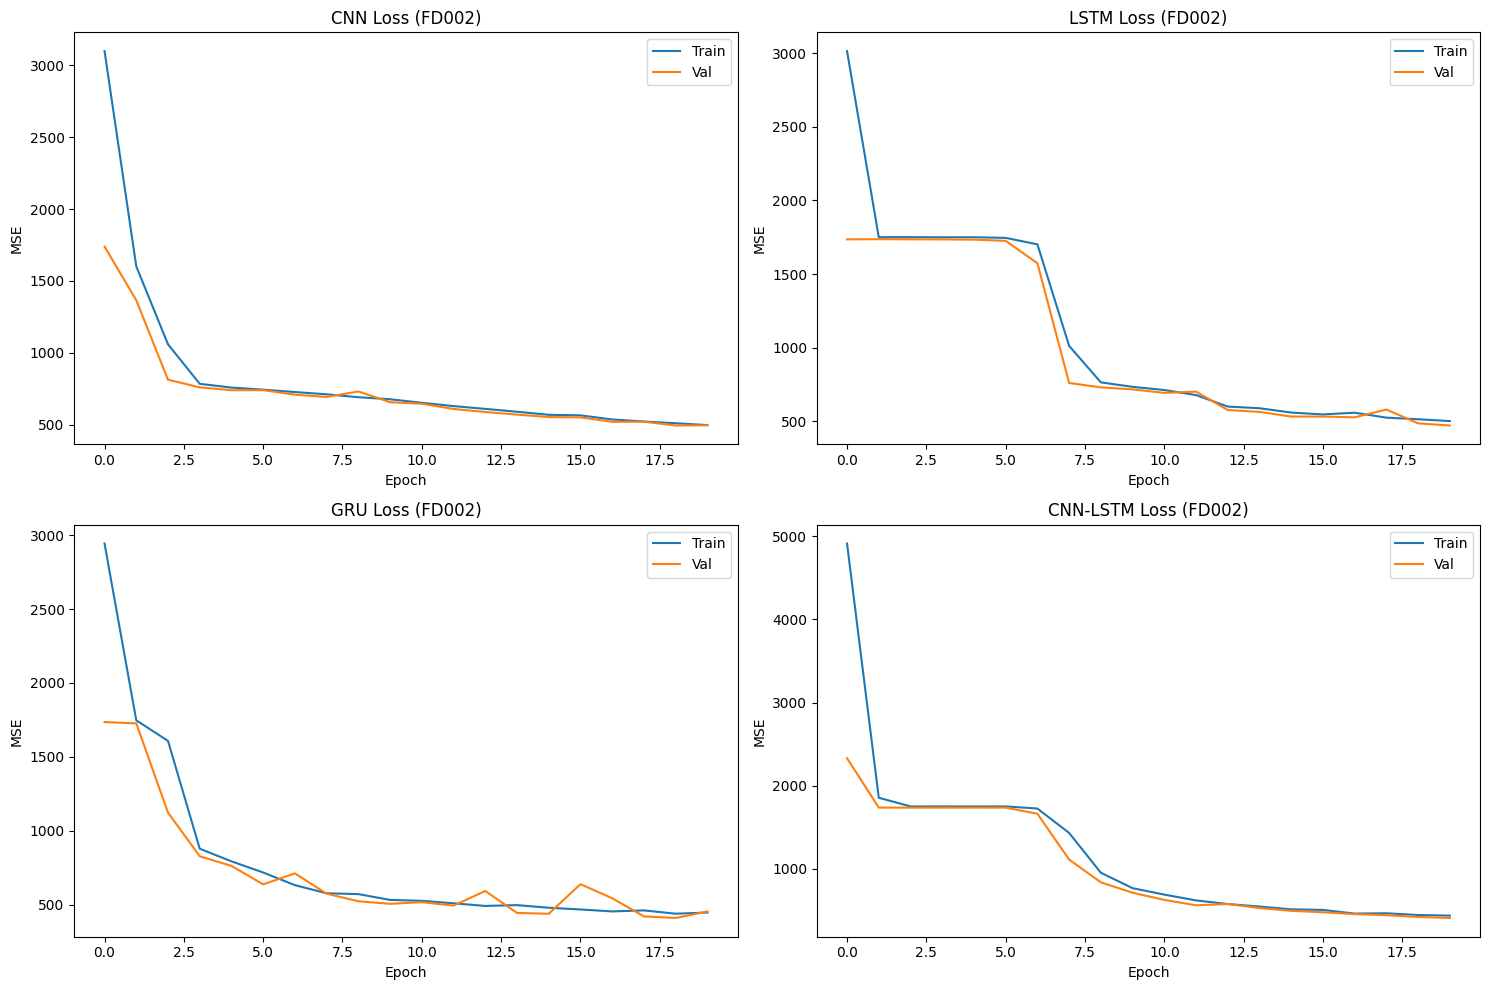

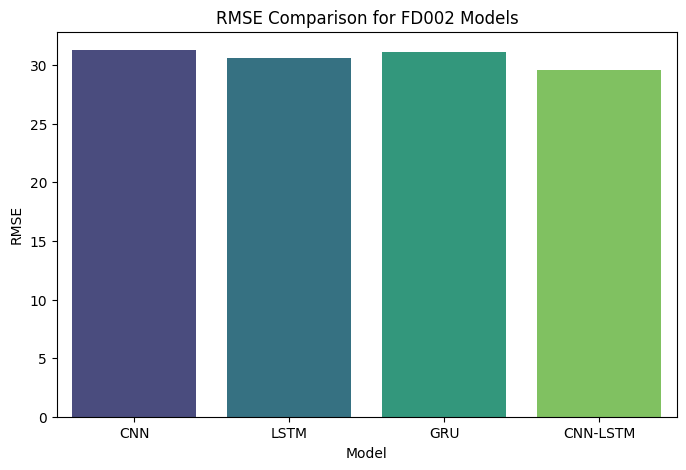


Final Metrics Table:
   Model      RMSE       R2
     CNN 31.286576 0.661550
    LSTM 30.604648 0.676143
     GRU 31.145170 0.664603
CNN-LSTM 29.589401 0.697274


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import joblib
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

# model imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Bidirectional, Flatten, TimeDistributed

# 1. SETUP & DATA LOADING
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

# UPDATE PATH FOR FD002
path = '/content/drive/MyDrive/Colab Notebooks/NASA Turbofan Jet Engine Data Set/data/'
df_train = pd.read_csv('/content/train_FD002.txt', sep='\\s+', header=None, index_col=False, names=col_names)
df_test = pd.read_csv('/content/test_FD002.txt', sep='\\s+', header=None, index_col=False, names=col_names)
y_test = pd.read_csv('/content/RUL_FD002.txt', sep='\\s+', header=None, index_col=False, names=['RUL'])

# 2. PREPROCESSING FUNCTIONS
def process_targets(data_length, early_rul):
    if data_length <= early_rul:
        return np.arange(data_length-1, -1, -1)
    else:
        return np.append(early_rul * np.ones(data_length - early_rul), np.arange(early_rul-1, -1, -1))

def process_input_data_with_targets(input_data, target_data, window_length, shift):
    # Padding logic for FD002 (some engines might be shorter than window_length)
    if len(input_data) < window_length:
        pad_len = window_length - len(input_data)
        input_data = np.pad(input_data, ((pad_len, 0), (0, 0)), mode='constant')
        if target_data is not None:
            target_data = np.pad(target_data, (pad_len, 0), mode='edge')

    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.zeros((num_batches, window_length, num_features))

    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(batch*shift):(batch*shift+window_length),:]
        return output_data
    else:
        output_targets = np.zeros(num_batches)
        for batch in range(num_batches):
            start, end = batch*shift, batch*shift+window_length
            output_data[batch,:,:] = input_data[start:end,:]
            output_targets[batch] = target_data[end-1]
        return output_data, output_targets

def process_test_data(test_data_unit, window_length, shift, num_test_windows=5):
    if len(test_data_unit) < window_length:
        pad_len = window_length - len(test_data_unit)
        test_data_unit = np.pad(test_data_unit, ((pad_len, 0), (0, 0)), mode='constant')

    max_batches = int(np.floor((len(test_data_unit) - window_length)/shift)) + 1
    num_windows = min(max_batches, num_test_windows)
    required_len = (num_windows - 1) * shift + window_length
    batched_test = process_input_data_with_targets(test_data_unit[-required_len:, :], None, window_length, shift)
    return batched_test, num_windows

# 3. FEATURE SELECTION & SCALING
# FD002 has more variance; we drop only truly constant sensors
drop_labels = df_train.columns[df_train.nunique() <= 1].tolist()
scaler = MinMaxScaler()

train_data_scaled = scaler.fit_transform(df_train.drop(columns=['unit_number'] + drop_labels))
test_data_scaled = scaler.transform(df_test.drop(columns=['unit_number'] + drop_labels))

# Save scaler for your maintenance system
joblib.dump(scaler, 'scaler_FD002.pkl')

train_df = pd.DataFrame(np.c_[df_train["unit_number"], train_data_scaled])
test_df = pd.DataFrame(np.c_[df_test["unit_number"], test_data_scaled])

# 4. DATA PREPARATION
window_length, shift, early_rul, num_test_windows = 30, 1, 125, 5
X_train, Y_train = [], []

for i in df_train['unit_number'].unique():
    temp_data = train_df[train_df[0] == i].drop(columns=[0]).values
    temp_targets = process_targets(temp_data.shape[0], early_rul)
    x, y = process_input_data_with_targets(temp_data, temp_targets, window_length, shift)
    X_train.append(x); Y_train.append(y)

X_train, Y_train = np.concatenate(X_train), np.concatenate(Y_train)
X_test, test_windows_list = [], []

for i in df_test['unit_number'].unique():
    temp_data = test_df[test_df[0] == i].drop(columns=[0]).values
    x, num_w = process_test_data(temp_data, window_length, shift, num_test_windows)
    X_test.append(x); test_windows_list.append(num_w)

X_test = np.concatenate(X_test)
Y_test_true = y_test.values.flatten()

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# 5. MODEL DEFINITIONS
def get_models(input_shape):
    return {
        "CNN": Sequential([
            layers.Conv1D(128, 3, activation='relu', input_shape=input_shape, padding='same'),
            layers.MaxPooling1D(2),
            layers.GlobalAveragePooling1D(),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "LSTM": Sequential([
            layers.LSTM(128, input_shape=input_shape),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "GRU": Sequential([
            layers.GRU(128, input_shape=input_shape),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "CNN-LSTM": Sequential([
            layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
            layers.MaxPooling1D(2),
            layers.LSTM(64),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
    }

# 6. TRAINING & EVALUATION
models = get_models((window_length, X_train.shape[2]))
history_data = {}
results = []



for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, Y_train, epochs=20, batch_size=256, validation_data=(X_val, Y_val), verbose=0)
    history_data[name] = history

    # Prediction
    raw_preds = model.predict(X_test, verbose=0).flatten()
    preds_split = np.split(raw_preds, np.cumsum(test_windows_list)[:-1])
    engine_preds = [np.mean(p) for p in preds_split]

    mse = mean_squared_error(Y_test_true, engine_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test_true, engine_preds)
    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})
    print(f"{name} Result -> RMSE: {rmse:.2f}, R2: {r2:.2f}")

# 7. VISUALIZATIONS
# Plot 1: Loss Curves
plt.figure(figsize=(15, 10))
for i, (name, history) in enumerate(history_data.items()):
    plt.subplot(2, 2, i+1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{name} Loss (FD002)')
    plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend()
plt.tight_layout(); plt.show()

# Plot 2: Final Performance Summary
res_df = pd.DataFrame(results)
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='RMSE', data=res_df, palette='viridis')
plt.title('RMSE Comparison for FD002 Models')
plt.show()

print("\nFinal Metrics Table:")
print(res_df.to_string(index=False))